<a href="https://colab.research.google.com/github/essential2189/ML_study/blob/main/Hands-On_ML/2.%20MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_openml

In [2]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()
# DESCR: 데이터셋 설명
# data: 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열
# target: 레이블 배열

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [3]:
X, y = mnist['data'], mnist['target']
X.shape, y.shape
# 28x28 = 784개의 feature

((70000, 784), (70000,))

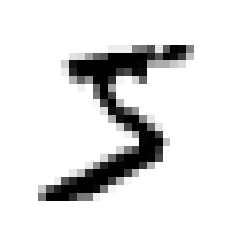

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [5]:
y[0]

'5'

In [6]:
# label이 문자열이다. 대부분 머신러닝 알고리즘은 숫자를 기대하므로 y를 정수로 변환.
y = y.astype(np.uint8)

In [7]:
# MNIST의 훈련 세트는 이미 섞여 있어서 모든 교차 검증 폴드를 비슷하게 만듬.
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [8]:
# 5만을 식별하는 이진 분류기
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [9]:
from sklearn.linear_model import SGDClassifier
# 확률적 경사 하강법 (Stochastic GD)

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])

array([ True])

In [13]:
# cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

# 3 fold
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.09735
0.09415
0.0978


In [14]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [15]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

# 모든 이미지를 '5 아님'으로 분류했을때 정확도 90% 나옴
# accuracy를 성능 측정 지표로 선호하지 않는 이유
# 불균형한 데이터셋(어떤 클래스가 다른 것보다 월등히 많은 겅우)을 다룰때 더욱 심하다

array([0.91125, 0.90855, 0.90915])

In [16]:
# 오차 행렬 (confusion matrix)
# 클래스 A를 클래스 B로 잘못 분류된 횟수를 세는 것.
# 분류기가 숫자 5의 이미지를 3으로 잘못 분류한 횟수 -> 오차 행렬의 5행 3열

# 먼저 실제 타깃과 비교를 위한 예측값 생성
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

# 오차 행렬 생성
# 행=실제 클래스, 열=예측한 클래스
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)
# 첫번째 행 '5 아님' 이미지를 '5 아님'으로 정확히 분류: 53057개, 나머지 1522개는 '5'라고 잘못 분류
# 두번째 행 '5' 이미지를 '5 아님'으로 잘못 분류: 1325개, 나머지 4096개는 정확히 '5'라고 분류
#                    예측
#               음성        양성
#       음성   53892        687
# 실제                             ㅅ
#       양성   1891         3530   | 정밀도
#                    <-재현율

array([[53892,   687],
       [ 1891,  3530]])

In [17]:
# 완벽한 분류기의 경우 진짜 양성과 진짜 음성만 있을 것이므로 오차 행렬의 주대각선만 0이 아님
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

In [18]:
from sklearn.metrics import precision_score, recall_score

# 정밀도 (precision)
precision_score(y_train_5, y_train_pred)
# 재현율 (recall)
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [19]:
# F1 score = 정밀도와 재현율의 조화 평균(harmonic mean)
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)
# 정밀도를 올리면 재현율이 줄고 그 반대도 마찬가지. 정밀도/재현율 트레이드오프

0.7325171197343846

In [21]:
y_score = sgd_clf.decision_function([some_digit])
print(y_score)
threshold = 0
y_some_digit_pred = (y_score > threshold)
y_some_digit_pred

# SGDClassifier의 임곗값이 0이므로 predict와 같은 결과 반환

[2164.22030239]


array([ True])

In [22]:
threshold = 8000
y_some_digit_pred = (y_score > threshold)
y_some_digit_pred

array([False])

In [23]:
# 모든 샘플의 점수를 구함 (예측 결과가 아닌 결정 점수 반환)
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5,
                            cv=3, method='decision_function')

In [24]:
# 모든 임계값에 대해 정밀도와 재현율을 계산
from sklearn.metircs import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='정밀도')
    plt.plot(thresholds, recalls[:-1], 'g-', label='재현율')

plot_precision_recall_vs_threshold(precision, recalls, thresholds)
plt.show()

ModuleNotFoundError: ignored